In [1]:
import torch
import numpy as np
from torch import nn, einsum
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt
import sys
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange

In [2]:
### WORK LOG ###

# this notebook is to try out an RIN arch for text.
# plan is to begin by adapting the main layers and training code from
# lucid rain's existing rin codebase for images. There are 2 things, in major
# to change: one is the embeddings at the interface input and the second is 
# tokenization. Tokenization can be tinkered with later on. We first
# begin by just trying out token embeddings instead of patch embeddings at
# interface input.

# the way the arch works is that we give token embeddings corrupted with
# gaussian noise as input, and pass it through a series of read-compute-write
# blocks and ultimately try to reconstruct the uncorrupted input.

# using sinusoidal embeddings for timesteps from Diffusion-LM. RIN has a module
# for the same too, but I believe it would be better to go with something that
# has worked with language before. They seem to be doing similar things, regardless.
# I have ported RIN one too, just in case.

# RIN uses a custom LN module without bias, saying it is more stable. 
# I am going to use the standard one from torch.

## NOTE ON PATCH SIZE AND NUMBER OF PATCHES
# (b, c, h, w) = (b, 3, 128, 128) => (b, (16*16), (3*8*8)) = [b, 256, 192]
# imagine an image with 3 channels, and each channel is an image of 128X128. 
# For each channel image, we want to divide it into 256 patches, each of size 8X8.
# You can also think about creating patches of the entire image, with the channels all 
# combined. 
# So we technically get 256 patches in total, each of size 8X8X3. So each patch is
# an embedding of dim 192.

### RIN block code flow
# input: patches=[bs, num_patches, dim], latents=[bs, num_latents, latent_dim], time_embedding=[bs, time_dim]
# num_patches = patch_h X patch_w
# In terms of its similarity with tensors for text sequences, you can think 
# of the 2nd dimesnion being seq_len for both patches and latents (which it actually is).
# The 2nd dim in patches is ph*pw => num_patches, and num_latents in latents.
# So the transformation from patches to latents involves compressing information
# along 2 axes, one across the sequence length (number of tokens) and the second 
# across the dimensionality of each token embedding. In this running example, we're only
# compressing across the first dimension and expanding across the second dimension
# (which kind of does not make sense lol). 
# 1. apply PEG layer (performs a 2d conv on the patches). No shape changes overall and would be irrelevant for text.
# 2. apply cross attention to project patches to latent space. Layer name is `latent_attends_to_patches`. 
# 3. apply ffn on cross attn output in latent space
# Note: in both 2 and 3, time_embedding is also passed. It's handled in different ways (not going into detail here).
# 4. loop in `latent_self_attns` which is a nn module list of Attention and FF layers.
#    apply attn and ff for each layer and add the residuals
# 5. an additional layer of self attention is applied. The layer is different (LinearAttention). Check.
# 6. apply cross attention from latent space to patches
# 7. apply ff in patch space, apply norm and return the final tensor.

## ATTENTION LAYER CODE FLOW (cross attention) ##
# input: latents = [bs, num_latents, latent_dim], patches = [bs, num_patches, dim], time = [bs, time_dim]
# 1. apply LN on patches
# 2. apply LN on latents
# 3. apply a sequential module on time input which consists of SiLU => Linear() => Rearrange(). 
#    The linear layer does not change the dimension of the vector. Rearrange adds an additional dimension at 1st index position
#    making the shape [bs, 1, time_dim]. The output of this layer is chunked across the last dimension into 2 tensors of
#    [bs, 1, time_dim//2]. The 2 tensors are called scale and shift. Not sure what they represent.
# 4. applied to latents: x = x*scale + shift.
# 5. 2 linear layers are defined to convert the inputs to relevant query and key values. For cross attention, latents are used
#    as queries and the patches are used as key and values. The projection of patches to kv is fused. (not sure how different this 
#    is than normal way of doing this projection separately.). First get q values by mapping latents and then kv. Dimensions of q,k,v are
#    head_dim*num_heads=model_dim. 
#    This operation gives q of shape [bs, num_latents, model_dim] and kv of shape [bs, num_patches, model_dim].
# 6. Reshape it to [bs, num_heads, num_latents (or num_patches), head_dim]. num_patches = num_latents.
# 7. In attend func: first mask if necessary (check since does not seem to happen in the image codebase).
# 8. Calculate similarity by multiplying q and k. Result is [bs, heads, num_latents, num_patches].
# 9. Multiply it by scale (model_dim ** -0.5).
# 10. Take softmax across last dim + dropout.
# 11. Multiply by v of shape [bs, heads, num_patches, head_dim] to get => [bs, heads, num_latents, head_dim].
# 12. Finally dim out to project it back to latent dim.


### NOTE ON ATTENTION vs LINEARATTENTION ###
# LinearAttention module is an efficient version of quadratic attention where k and v are multiplied first and the result is
# multiplied with q. Softmax is applied before taking products at relevant places. The overall result stands because it can be derived
# as a low rank approximation for the quadratic attention. 
# I can port it for now, but initially we can choose to just use the normal quadratic attention. I am also not sure how helpful linear
# attention is when applied to latents. As it is latents are the compressed version of the actual interface tokens. Per my understanding, it
# would make more sense to use it for longer sequences. Perhaps its more common in image datasets with high resolution data points.

# TODO: read more about `latent_token_time_cond` flag, what it signifies and the literature around it.
# TODO: understand what learned sinusoidal pos embedding does.


### FFN CODE FLOW ###
# 1. Apply LN on input x.
# 2. If time_cond_dim is passed in the initialization, add that information to the input by applying a net with SiLU() + Linear() + Rearrange().
#    The output is chunked across the last dim to get scale and shift. Then x = x * scale + shift. 
# 3. Linear() + GeLU() + Linear() is applied where first linear projects it to dim*4, and the final linear projects it back to dim.


### PLANNING ###
# (read/understand individual modules and adapt them for text)
# Read Attention and LinearAttention modules, figure out which is needed. 
# Rewrite the classes with more favorable naming.
# Rewrite FFN.
# Note how LN is used in text models (diffusion-lm) and use it in that way over here instead of using the image conventions.
# Rewrite RINBlock and stitch all the previous layers
# Rewrite RIN with previous layers. 

In [3]:
def timestep_embedding(timesteps, dim, max_period=10000):
    # timesteps = [bs]
    # dim = 128
    """
    Create sinusoidal timestep embeddings.

    :param timesteps: a 1-D Tensor of N indices, one per batch element.
                      These may be fractional.
    :param dim: the dimension of the output.
    :param max_period: controls the minimum frequency of the embeddings.
    :return: an [N x dim] Tensor of positional embeddings.
    """
    half = dim // 2
    # 64
    freqs = torch.exp(
        -math.log(max_period) * torch.arange(start=0, end=half, dtype=torch.float32) / half
    ).to(device=timesteps.device)
    # exp{-(T * t)/64}, where T is the time period, t is the current time instant
    args = timesteps[:, None].float() * freqs[None]
    embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
    if dim % 2:
        embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
        # TODO: why cating zeros?
    return embedding

In [4]:
emb = timestep_embedding(torch.arange(32), dim=128)
emb.shape

torch.Size([32, 128])

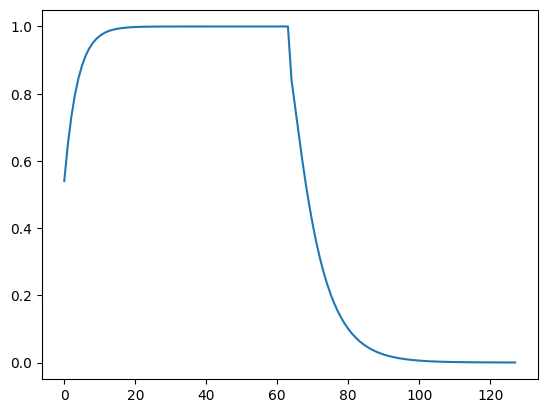

In [5]:
plt.plot(emb[1].tolist())

In [6]:
class LearnedSinusoidalPosEmb(nn.Module): # used in RIN (image modality)
    def __init__(self, dim):
        super().__init__()
        assert (dim % 2) == 0
        half_dim = dim // 2
        self.weights = nn.Parameter(torch.randn(half_dim))

    def forward(self, x):
        x = rearrange(x, 'b -> b 1')
        freqs = x * rearrange(self.weights, 'd -> 1 d') * 2 * math.pi
        fouriered = torch.cat((freqs.sin(), freqs.cos()), dim = -1)
        fouriered = torch.cat((x, fouriered), dim = -1)
        return fouriered

In [7]:
emb = LearnedSinusoidalPosEmb(128)
# plt.plot(emb.forward(torch.arange(32))[1].tolist())

# the embedding graph does not look as structured as the previous most likely
# because this is a learnable embedding unlike the previous one.

In [30]:
class Attention(nn.Module):
    def __init__(
        self,
        output_dim:int, # the expected output dimensionality after cross attention (query dimensionality)
        context_dim:int, # dimensionality of the current stream of computation (kv dimensionality)
        num_heads:int,
        head_dim:int,
        time_dim:int,
        attn_dropout:float,
        input_norm:bool,
        context_norm:bool,
        qk_norm:bool
    ):

        super().__init__()
        
        attn_dim = head_dim * num_heads
        self.scale = head_dim ** -0.5
        self.num_heads = num_heads
        self.attn_dropout = attn_dropout
        
        if context_dim is None:
            context_dim = output_dim
        
        if time_dim is not None:
            self.time_mlp = nn.Sequential(
                nn.GELU(),
                nn.Linear(time_dim, output_dim*2),
                Rearrange('b d -> b 1 d')
            )

            # TODO: does this make sense for text?
            nn.init.zeros_(self.time_mlp[-2].weight)
            nn.init.zeros_(self.time_mlp[-2].bias)

        # TODO: needed for text?
        self.input_ln = nn.LayerNorm(output_dim) if input_norm else nn.Identity()
        self.context_ln = nn.LayerNorm(context_dim) if context_norm else nn.Identity()

        self.to_q = nn.Linear(output_dim, attn_dim, bias=False)
        # TODO: how is this different than separately projecting k and v
        self.to_kv = nn.Linear(context_dim, attn_dim*2, bias=False)
        self.to_out = nn.Linear(attn_dim, output_dim, bias=False)

    def attend(self, q, k, v, mask=None):
        sim = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale
        if mask is not None: # TODO: check if we need masking
            sim = sim.masked_fill(~mask, -torch.finfo(sim.dtype).max)

        attn = sim.softmax(dim=-1)
        attn = F.dropout(attn, p=self.attn_dropout)
        out = einsum('b h i j, b h j d -> b h i d', attn, v)
        return out
        

    def forward(
        self,
        inp,
        context,
        time
    ):
        h = self.num_heads
        if context is not None:
            context = self.context_ln(context)

        inp = self.input_ln(inp)
        if context is None:
            context = inp

        scale, shift = self.time_mlp(time).chunk(2, dim=-1)
        inp = (inp * (scale + 1)) + shift

        qkv = (self.to_q(inp), *self.to_kv(context).chunk(2, dim=-1))

        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=h), qkv)

        out = self.attend(q, k, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)        

In [32]:
def test_attention_module():
    attn = Attention(512, 256, 4, 32, 1024, 0.2, True, True, True)
    
    inp = torch.randn(32, 128, 512)
    context = torch.randn(32, 256, 256)
    time = torch.randn(32, 1024)
    attn_out = attn(inp, context, time)
    assert attn_out.shape == torch.randn(32, 128, 512).shape

test_attention_module()

In [33]:
class FeedForwardLayer(nn.Module):
    def __init__(
        self,
        input_dim:int,
        time_dim:int,
        mult_factor:int
    ):
        super().__init__()
        self.norm = nn.LayerNorm(input_dim)
        if time_dim is not None:
            self.time_mlp = nn.Sequential(
                nn.GELU(),
                nn.Linear(time_dim, input_dim*2),
                Rearrange("b d -> b 1 d")
            )
            nn.init.zeros_(self.time_mlp[-2].weight)
            nn.init.zeros_(self.time_mlp[-2].bias)

        inner_dim = input_dim*mult_factor
        self.ffn = nn.Sequential(
            nn.Linear(input_dim, inner_dim),
            nn.GELU(),
            nn.Linear(inner_dim, input_dim)
        )

    def forward(self, x, time=None):

        x = self.norm(x)
        if time is not None:
            scale, shift = self.time_mlp(time).chunk(2, dim=-1)
            x = (x*(scale+1)) + shift

        return self.ffn(x)       

In [34]:
def test_ffn_module():
    ffn = FeedForwardLayer(256, 1024, 4)
    inp = torch.randn(32, 128, 256)
    time = torch.randn(32, 1024)
    ffn_out = ffn(inp, time)
    assert ffn_out.shape == torch.randn(32, 128, 256).shape

test_ffn_module()

In [51]:
class RINBlock(nn.Module):
    def __init__(
        self,
        config,
        interface_dim:int,
        num_latent_attn_layers:int,
        latent_dim:int,
        time_dim:int,
        final_norm:bool
    ):
        super().__init__()

        attn_kwargs = {
            "num_heads": config.num_heads,
            "head_dim": config.head_dim,
            "time_dim": config.time_dim,
            "attn_dropout": config.attn_dropout,
            "input_norm": config.input_norm,
            "context_norm": config.context_norm,
            "qk_norm": config.qk_norm
        }
        self.interface_to_latents_cross_attn = Attention(
            output_dim=latent_dim,
            context_dim=interface_dim,
            **attn_kwargs
        )

        self.latents_ffn = FeedForwardLayer(
            input_dim=latent_dim,
            time_dim=time_dim,
            mult_factor=config.mult_factor
        )

        self.latent_self_attn_layers = nn.ModuleList([])
        for _ in range(num_latent_attn_layers):
            self.latent_self_attn_layers.append(
                nn.ModuleList([
                    Attention(
                        output_dim=latent_dim,
                        context_dim=None,
                        **attn_kwargs
                    ),
                    FeedForwardLayer(
                        input_dim=latent_dim,
                        time_dim=time_dim,
                        mult_factor=config.mult_factor
                    )
                ])
            )

        self.latent_final_norm = nn.LayerNorm(latent_dim) if final_norm else nn.Identity()
        self.latents_to_interface_cross_attn = Attention(
            output_dim=interface_dim,
            context_dim=latent_dim,
            **attn_kwargs
        )
        self.interface_ffn = FeedForwardLayer(
            input_dim=interface_dim,
            time_dim=time_dim,
            mult_factor=config.mult_factor
        )

    def forward(
        self,
        interface,
        latents,
        time
    ):
        latents = self.interface_to_latents_cross_attn(latents, interface, time) + latents
        latents = self.latents_ffn(latents, time) + latents
        
        for attn, ffn in self.latent_self_attn_layers:
            latents = attn(latents, latents, time=time) + latents
            latents = ffn(latents, time) + latents
        
        interface = self.latents_to_interface_cross_attn(interface, latents, time) + interface
        interface = self.interface_ffn(interface, time) + interface
        
        latents = self.latent_final_norm(latents)
        
        return interface, latents


In [52]:
class Config:
    def __init__(
        self,
        num_heads,
        head_dim,
        time_dim,
        attn_dropout,
        mult_factor,
        input_norm,
        context_norm,
        qk_norm
    ):
        self.num_heads = num_heads
        self.head_dim = head_dim
        self.time_dim = time_dim
        self.mult_factor = mult_factor
        self.attn_dropout = attn_dropout
        self.input_norm = input_norm
        self.context_norm = context_norm
        self.qk_norm = qk_norm
        

In [54]:
def test_rin_block_module():
    config = Config(4,32,512,0.4,4,True,True,True)   
    rinblock = RINBlock(config, 256, 4, 512, 512, True)
    interface = torch.randn(32, 256, 256)
    latents = torch.randn(32, 128, 512)
    time = torch.randn(32, 512)
    interface, latents = rinblock(interface, latents, time)
    assert interface.shape == torch.randn(32, 256, 256).shape
    assert latents.shape == torch.randn(32, 128, 512).shape

In [56]:
# Instead of code related to patches, we need to have something related to text.
# the process of converting image to patches and then to patch embedding needs to be replaced
# by something like word embeddings. 
# This could be byte embeddings or word embeddings (sub-word) to begin with.
class RIN(nn.Module): ### WIP ###
    def __init__(
        self,
        hidden_dim:int,
        num_rin_blocks:int,
        num_latent_attn_layers:int,
        vocab_size:int,
        interface_emb_dim:int, # embedding size of words in interface
        latent_dim:int,
        num_latents:int,
        learned_sinusoidal_dim:int, # TODO: check if needed
        latent_token_time_cond:bool,        
    ):
        super().__init__()
        self.latent_token_time_cond = latent_token_time_cond
        self.interface_embedding = nn.Embedding(vocab_size, interface_emb_dim)

        sinusoidal_pos_embedding = LearnedSinusoidalPosEmb(learned_sinusoidal_dim)
        time_dim = hidden_dim*4
        fourier_dim = learned_sinusoidal_dim + 1
        self.time_mlp = nn.Sequential(
            sinusoidal_pos_embedding,
            nn.Linear(fourier_dim, time_dim),
            nn.GELU(),
            nn.Linear(time_dim, time_dim)
        )

        self.latents = nn.Parameter(torch.randn(num_latents, latent_dim))
        nn.init.normal_(self.latents, std=0.02)
        self.initial_latents = nn.Sequential(
            FeedForwardLayer(latent_dim),
            nn.LayerNorm(latent_dim)
        )
        nn.init.zeros_(self.initial_latents[-1].gamma)

        self.rin_blocks = nn.ModuleList([
            RINBlock(
                config,
                hidden_dim,
                num_latent_attn_layers,
                latent_dim,
                time_dim,
                config.final_norm
            ) for _ in range(num_rin_blocks)
        ])
        self.unembed = nn.Linear(hidden_dim, vocab_size)
        # TODO: check if this should be tied to embedding weight

    def forward(self, input_tokens, time, input_self_cond, latent_self_cond, return_latents):
        # check if input_self_cond (input self conditioning - at interface) is done. 
        # I only remember it being done for latents. Not adding code for that right now.

        batch_size = input_tokens.shape[0]
        time_emb = self.time_mlp(time)

        latents = repeat(self.latents, 'n d -> b n d', b=batch_size)
        if latent_self_cond is not None:
            latents = latents + self.initial_latents(latent_self_cond)

        # TODO: not sure about the theory behind this. Just copied for now. Check if needed.
        if self.latent_token_time_cond:
            # whether the time conditioning is to be treated as one latent token or for 
            # projecting into scale and shift for adaptive layernorm
            time_emb = rearrange(time_emb, 'b d -> b 1 d')
            latents = torch.cat([latents, time_emb], dim=-2)

        interface_emb = self.interface_embedding(input_tokens)
        # TODO: add positional embedding for tokens

        for rin_block in self.rin_blocks:
            interface, latents = rin_block(interface_emb, latents, time_emb)

        out = self.unembed(interface)
        # need to take softmax to get the predicted tokens

        return out, latents